# Sampleo imágenes Fashion MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import make_grid

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Arquitecturas de modelos generativos

In [56]:
class Generator(nn.Module):
  def __init__(self, input_dim=100, out_dim=(1,28,28), class_num=10):
    super(Generator, self).__init__()
    self.out_dim = out_dim
    self.input_dim = input_dim
    self.label_emb = nn.Embedding(class_num, class_num)

    self.fc1 = nn.Sequential(nn.Linear(input_dim + class_num, 256),
                             nn.LeakyReLU(0.2, inplace=True))
    self.fc2 = nn.Sequential(nn.Linear(256, 512),
                             nn.LeakyReLU(0.2, inplace=True))

    # Parte intermedia
    self.ib = nn.Sequential(nn.Linear(512, 512),
                            nn.LeakyReLU(0.2, inplace=True))

    self.fc3 = nn.Sequential(nn.Linear(512, 1024),
                             nn.LeakyReLU(0.2, inplace=True))
    self.fc4 = nn.Sequential(nn.Linear(1024, out_dim[0]*out_dim[1]*out_dim[2]),
                             nn.Tanh())

  def forward(self, x, labels):
    x = x.view(-1, self.input_dim)
    o_hot = self.label_emb(labels)
    x = torch.cat([x, o_hot], dim=1)
    x = self.fc1(x)
    x = self.fc2(x)

    x = self.ib(x)

    x = self.fc3(x)
    x = self.fc4(x)
    x = x.view(-1, self.out_dim[0], self.out_dim[1], self.out_dim[2])
    return x

In [31]:
class UNet(nn.Module):
  def __init__(self, input_dim=100, out_dim=(3,28,28),  class_num=6):
    super(UNet, self).__init__()
    self.out_dim = out_dim
    self.input_dim = input_dim
    self.label_emb = nn.Embedding(class_num, class_num)
    self.init = nn.Sequential(nn.Linear(input_dim + class_num, 2352),
                              nn.LeakyReLU(0.2, inplace=True))
    # Capas convolucionales descendentes
    self.down1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                               nn.BatchNorm2d(64),
                               nn.ReLU(inplace=True))
    self.down2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                               nn.BatchNorm2d(128),
                               nn.ReLU(inplace=True))
    self.down3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1),
                               nn.BatchNorm2d(128),
                               nn.ReLU(inplace=True))

    # Capas convolucionales ascendentes
    self.up1 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1),
                               nn.BatchNorm2d(128),
                               nn.ReLU(inplace=True))
    self.up2 = nn.Sequential(nn.Conv2d(128 * 2, 64, kernel_size=3, padding=1),
                               nn.BatchNorm2d(64),
                               nn.ReLU(inplace=True))
    self.up3 = nn.Sequential(nn.Conv2d(64 * 2, out_dim[0], kernel_size=3, padding=1),
                             nn.Tanh())

    # Capas de sub-muestreo y sobre-muestreo
    self.sub = nn.MaxPool2d(2)
    self.sobre = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

  def forward(self, x, labels):
    x = x.view(-1, self.input_dim)
    o_hot = self.label_emb(labels)
    x = torch.cat([x, o_hot], dim=1)
    x = self.init(x)
    x = x.view(-1, self.out_dim[0], self.out_dim[1], self.out_dim[2])

    x1 = self.down1(x)
    x2 = self.down2(self.sub(x1))
    x3 = self.down3(self.sub(x2))

    x4 = self.sobre(self.up1(x3))
    x5 = self.sobre(self.up2(torch.cat([x2, x4], dim=1))) # Skip connection
    x6 = self.up3(torch.cat([x1, x5], dim=1)) # Skip connection
    x6 = x6.view(-1, self.out_dim[0], self.out_dim[1], self.out_dim[2])

    return x6

In [9]:
class EncDec(nn.Module):
  def __init__(self, input_dim=100, out_dim=(3,28,28), class_num=6):
    super(EncDec, self).__init__()
    self.out_dim = out_dim
    self.input_dim = input_dim
    self.label_emb = nn.Embedding(class_num, class_num)
    # Encoder
    self.enc1 = nn.Sequential(nn.Linear(input_dim + class_num, 1024),
                              nn.LeakyReLU(0.2, inplace=True))
    self.enc2 = nn.Sequential(nn.Linear(1024, 512),
                              nn.LeakyReLU(0.2, inplace=True))

    # Parte intermedia
    self.ib = nn.Sequential(nn.Linear(512, 512),
                            nn.LeakyReLU(0.2, inplace=True))

    # Decoder
    self.dec1 = nn.Sequential(nn.Linear(512, 1024),
                              nn.LeakyReLU(0.2, inplace=True))
    self.dec2 = nn.Sequential(nn.Linear(1024, out_dim[0]*out_dim[1]*out_dim[2]),
                              nn.Tanh())

  def forward(self, x, labels):
    x = x.view(x.shape[0], self.input_dim)
    o_hot = self.label_emb(labels)
    x = torch.cat([x, o_hot], dim=1)
    x = self.enc1(x)
    x = self.enc2(x)

    x = self.ib(x)

    x = self.dec1(x)
    x = self.dec2(x)
    x = x.view(-1, self.out_dim[0], self.out_dim[1], self.out_dim[2])
    return x

In [10]:
class FullyConnected(nn.Module):
  def __init__(self, input_dim=100, out_dim=(3,28,28), class_num=6):
    super(FullyConnected, self).__init__()
    self.out_dim = out_dim
    self.input_dim = input_dim
    self.label_emb = nn.Embedding(class_num, class_num)

    self.fc1 = nn.Sequential(nn.Linear(input_dim + class_num, 256),
                             nn.LeakyReLU(0.2, inplace=True))
    self.fc2 = nn.Sequential(nn.Linear(256, 512),
                             nn.LeakyReLU(0.2, inplace=True))

    # Parte intermedia
    self.ib = nn.Sequential(nn.Linear(512, 512),
                            nn.LeakyReLU(0.2, inplace=True))

    self.fc3 = nn.Sequential(nn.Linear(512, 1024),
                             nn.LeakyReLU(0.2, inplace=True))
    self.fc4 = nn.Sequential(nn.Linear(1024, out_dim[0]*out_dim[1]*out_dim[2]),
                             nn.Tanh())

  def forward(self, x, labels):
    x = x.view(-1, self.input_dim)
    o_hot = self.label_emb(labels)
    x = torch.cat([x, o_hot], dim=1)
    x = self.fc1(x)
    x = self.fc2(x)

    x = self.ib(x)

    x = self.fc3(x)
    x = self.fc4(x)
    x = x.view(-1, self.out_dim[0], self.out_dim[1], self.out_dim[2])
    return x

## Carga del modelo

In [48]:
def load_model(generator_model, path_model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  if device == 'cuda':
    checkpoint = torch.load(path_model)
    generator_model.load_state_dict(checkpoint)
  else:
    checkpoint = torch.load(path_model, map_location=torch.device('cpu'))
    generator_model.load_state_dict(checkpoint)
  return generator_model

In [81]:
z_size = 100
class_num = 6 # Cambiar
image_dim = (3, 28, 28) # Cambiar

# Instanciar el modelo que se quiera ocupar
# model = Generator(input_dim=z_size,
#                   class_num=10).to(device)
model = EncDec(out_dim=image_dim,
               class_num=class_num)
ruta = "/models/generator_faces_28p.pt" # Modificar el modelo que se quiera cargar

generator = load_model(model, ruta)

# Sampleo

In [86]:
def sample_images(model, labels, z_size=100):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  z = Variable(torch.randn(labels.size()[0], z_size)).to(device)
  labels = labels.to(device)

  sample_images = model(z, labels).data.cpu()

  grid = make_grid(sample_images, normalize=True).permute(1,2,0).numpy()
  fig, ax = plt.subplots(figsize=(8,8))
  plt.imshow(grid)
  plt.axis('off')

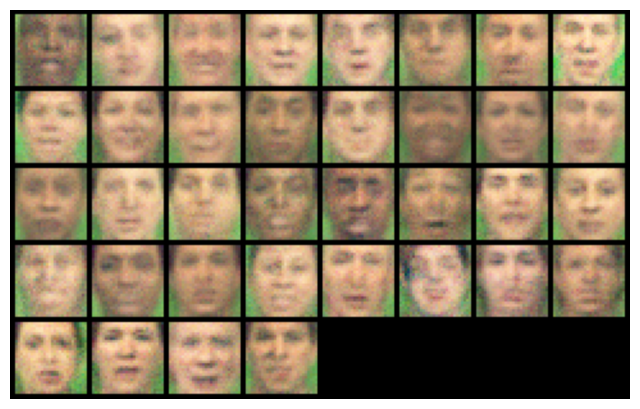

In [87]:
# Fashion MNIST = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Faces CREMA-D = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
#                 [0, 1, 2, 3, 4, 5, 6]

# Labels tiene que tener dimension 100 para Fashion MNIST, y 36 para cara de CREMA-D
labels = torch.LongTensor([np.random.randint(0, class_num) for _ in range(class_num) for i in range(class_num)])
sample_images(generator, labels)